Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine
import psutil


Koneksi ke database & ambil data

In [2]:
engine = create_engine("mysql+pymysql://root:@localhost/magang")
query = """
SELECT waktu, voltage, current, power, frequency, powerfactor
FROM meter_1
"""
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')
print(f"Jumlah Baris = {df.shape[0]}")
display(df.head())


Jumlah Baris = 3100


,voltage,current,power,frequency,powerfactor
waktu,,,,,
2025-01-28 07:41:46,380.78,32.03,20.58,49.98,0.97
2025-01-28 07:41:48,380.78,32.03,20.52,49.98,0.97
2025-01-28 07:41:55,380.35,31.99,20.52,49.98,0.97
2025-01-28 07:42:01,380.35,31.99,20.53,49.98,0.97
2025-01-28 07:42:04,380.49,31.97,20.53,49.99,0.97


Visualisasi data awal

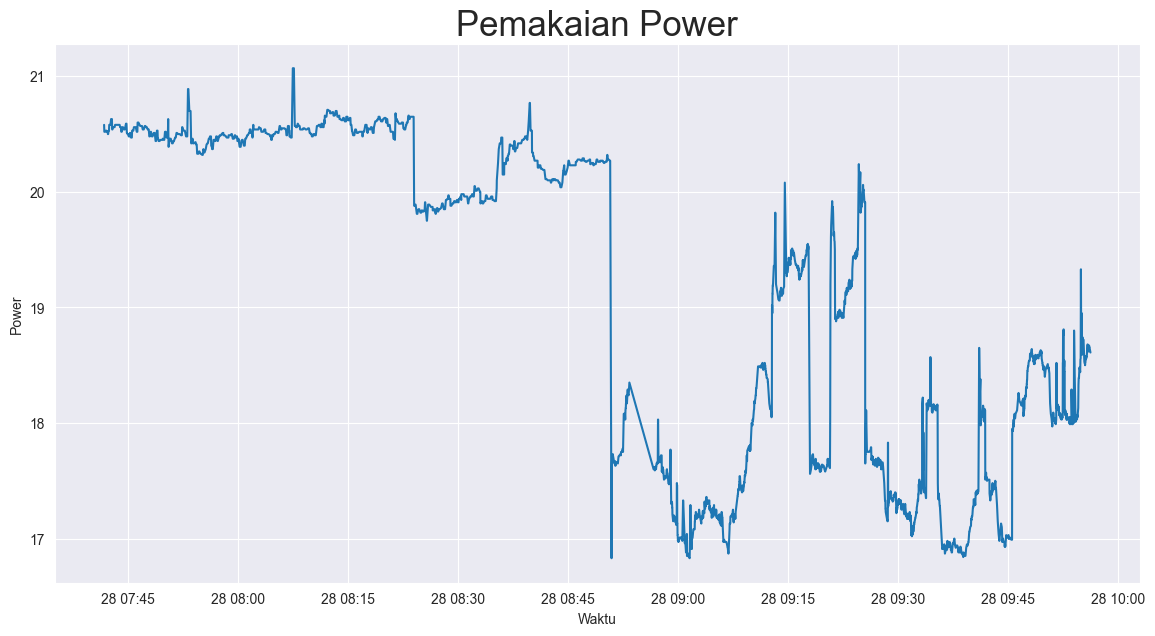

In [3]:
plt.figure(figsize=(14, 7))
sns.set_style('darkgrid')
plt.plot(df.index, df['power'])
plt.title("Pemakaian Power", fontsize=25)
plt.xlabel("Waktu")
plt.ylabel("Power")
plt.show()

Preprocessing

In [4]:
df = pd.read_sql(query, con=engine)
df['waktu'] = pd.to_datetime(df['waktu'])
df.set_index('waktu', inplace=True)
print(df.isnull().sum())
df.dropna(inplace=True)
X = df.drop(columns='power')  
y = df['power']              


voltage        0
current        0
power          0
frequency      0
powerfactor    0
dtype: int64


Split Data untuk Training dan Testing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

80% training 20% testing

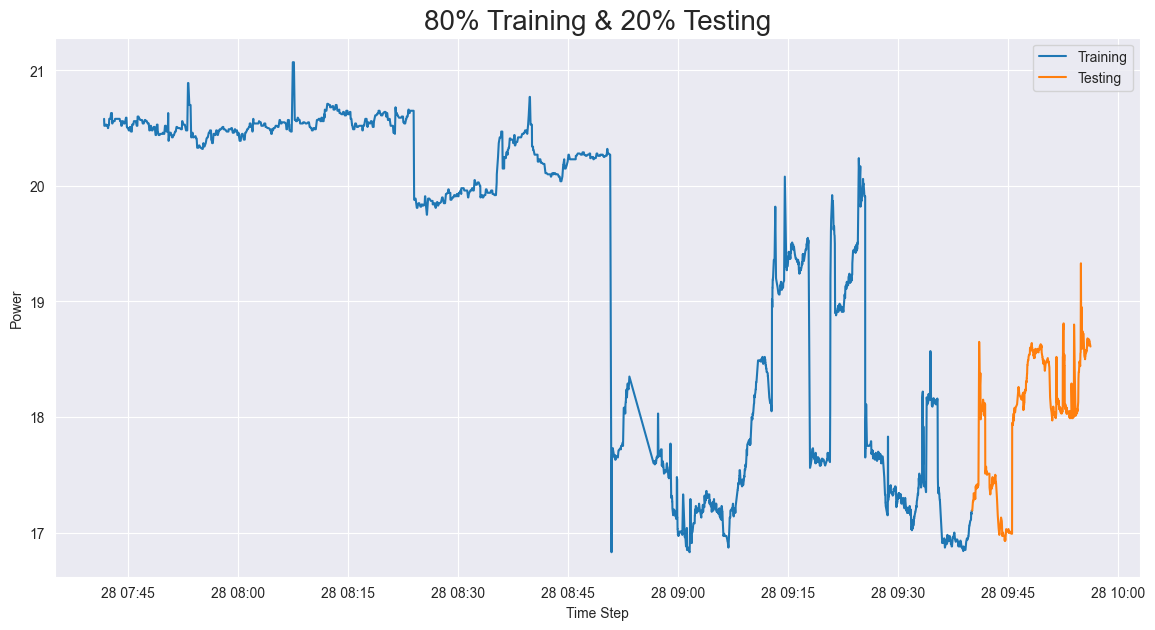

In [6]:
def split_data(data, train_size=0.8):
    train_len = int(len(data) * train_size)
    train = data[:train_len]
    test = data[train_len:]
    return train, test
train, test = split_data(df['power'], 0.8)

plt.figure(figsize=(14, 7))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('80% Training & 20% Testing', fontsize=20)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

Training Model dan evaluasi ExtraTrees

In [7]:
process = psutil.Process()

# Cek memory sebelum training
mem_before = process.memory_info().rss / (1024 ** 2)  # dalam MB

# Model Random Forest
model = ExtraTreesRegressor(n_estimators=1000, random_state=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Cek memory sesudah training
mem_after = process.memory_info().rss / (1024 ** 2)  # dalam MB
mem_used = mem_after - mem_before

# Evaluasi
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Hasil
print(f"📊 Evaluasi Model Random Forest:")
print(f"- Mean Squared Error (MSE)              : {mse:.4f} kW²")
print(f"- Root Mean Squared Error (RMSE)        : {rmse:.4f} kW")
print(f"- Mean Absolute Error (MAE)             : {mae:.4f} kW")
print(f"- Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
print(f"- R-squared (R² Score)                  : {r2:.4f}")
print(f"- Memori Terpakai Selama Training       : {mem_used:.2f} MB")

📊 Evaluasi Model Random Forest:
- Mean Squared Error (MSE)              : 0.0162 kW²
- Root Mean Squared Error (RMSE)        : 0.1273 kW
- Mean Absolute Error (MAE)             : 0.0520 kW
- Mean Absolute Percentage Error (MAPE) : 0.28%
- R-squared (R² Score)                  : 0.9900
- Memori Terpakai Selama Training       : 201.20 MB


Visualisasi Prediksi vs Aktual

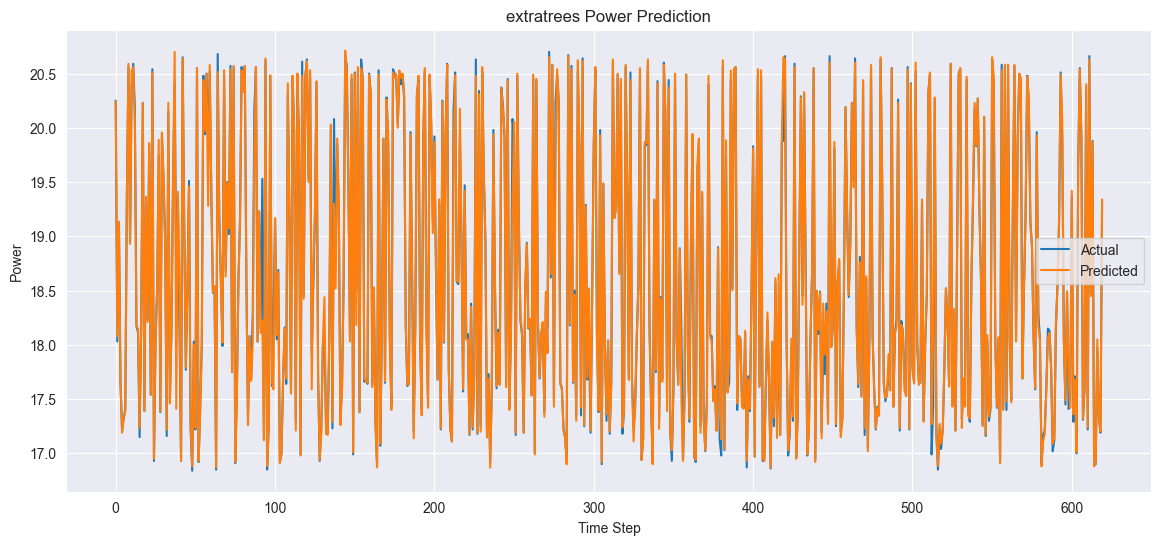

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('extratrees Power Prediction')
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

Visualisasi Prediksi vs Aktual (200 Data Terakhir)

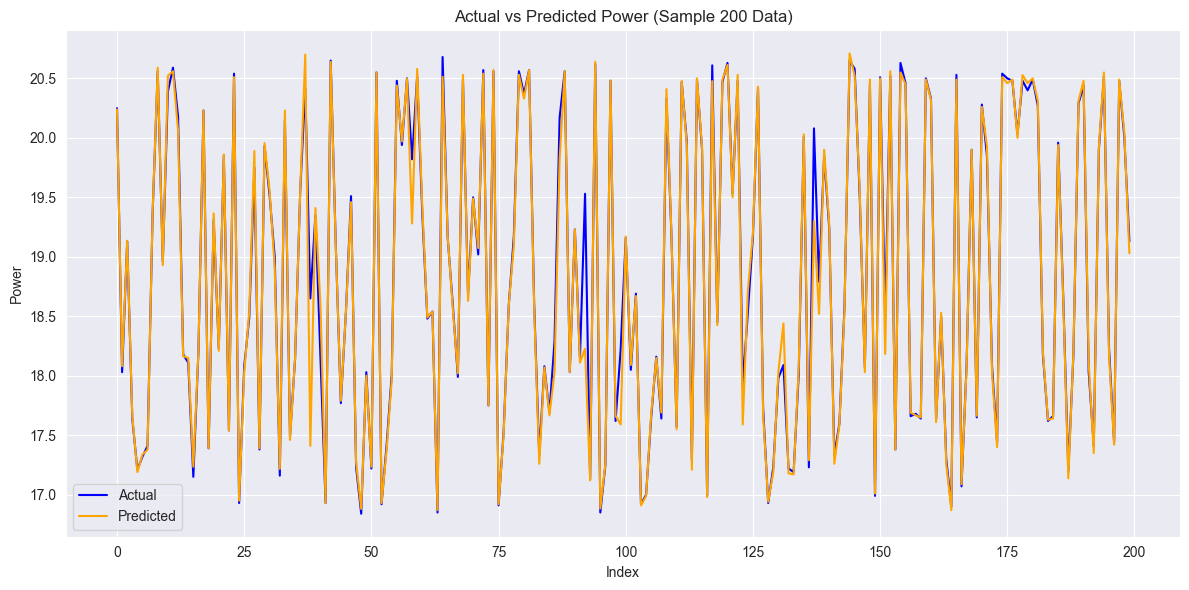

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='orange')
plt.title('Actual vs Predicted Power (Sample 200 Data)')
plt.xlabel('Index')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


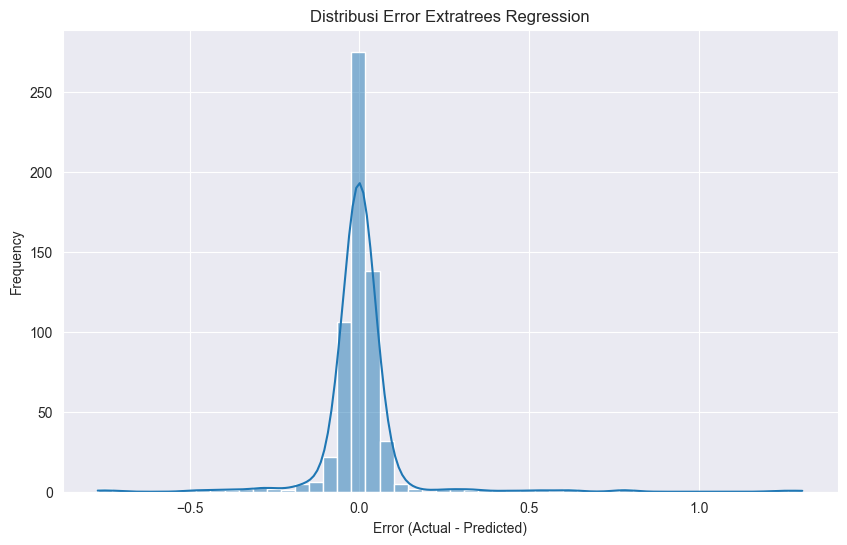

In [11]:
errors = y_test.values - y_pred
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=50, kde=True)
plt.title("Distribusi Error Extratrees Regression")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()
